In [1]:
import os
os.chdir(os.path.expanduser('~/My Drive/dirclip-private/core'))

In [2]:
from jax import config
config.update('jax_enable_x64', True)

In [3]:
import re
import jax
import numpy as np
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
from jax import vmap

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# likelihood comparison

In [5]:
def pdf_cold_fn(x, T, normalize=False):
    log_prob = (1/T) * jnp.log(x)
    norm_const = jnp.log(T) - jnp.log1p(T)
    if normalize: log_prob -= norm_const
    return jnp.exp(log_prob)

def pdf_conf_fn(x, T, normalize=False):
    log_prob = jnp.log(x) + (1/T-1)*jnp.log(jnp.maximum(x, 1-x))
    norm_const = jnp.log(T) + jnp.log1p(-2**(-1/T))
    if normalize: log_prob -= norm_const
    return jnp.exp(log_prob)

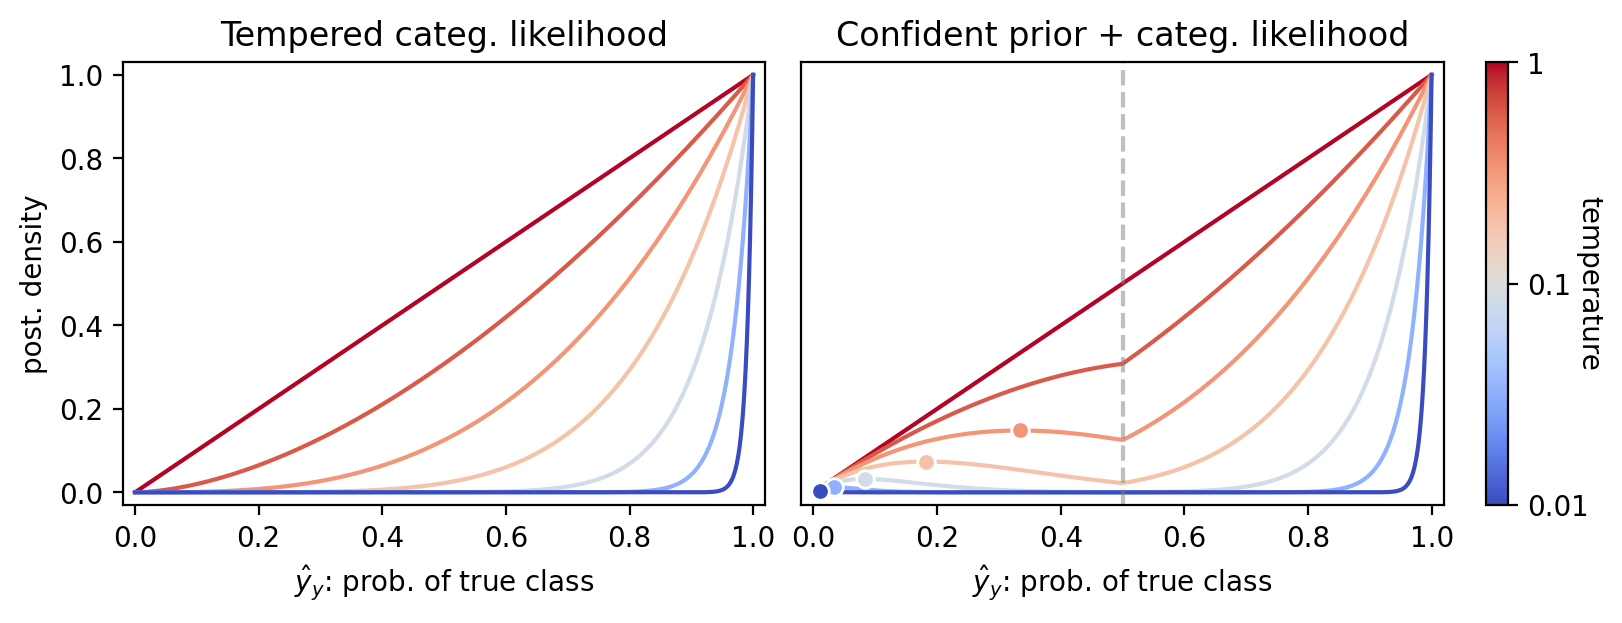

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), layout='constrained')
x = jnp.linspace(0, 1, 10_000)

# set temperatures to plot
temps = 1 / jnp.array([1, 1.7, 3, 5.5, 12, 30, 100])
color_mapper = mpl.cm.ScalarMappable(cmap='coolwarm')
colors = color_mapper.to_rgba(jnp.log(temps))

# plot density for each temperature
for i, pdf_fn in enumerate((pdf_cold_fn, pdf_conf_fn)):
    for T, c in zip(temps, colors):
        # plot density
        y = pdf_fn(x, T, normalize=False)
        axs[i].plot(x, y, c=c)
        
        # plot local maximum
        idx = jnp.where((y[0:-3] < y[1:-2]) & (y[1:-2] > y[2:-1]))[0]
        if len(idx): axs[1].scatter([x[idx[0]+1]], [y[idx[0]+1]], color=c, edgecolor='white', marker='o', s=40, zorder=100)

# colorbar
cbar = fig.colorbar(color_mapper, ax=axs[1], location='right', format=lambda x, _: f'{np.round(np.exp(x), decimals=5):g}')
cbar.set_ticks(jnp.log(jnp.array([1, 0.1, 0.01])))
cbar.ax.set_ylabel('temperature', rotation=-90, labelpad=5)

# extras
axs[0].set_ylabel('post. density')
axs[0].set_title('Tempered categ. likelihood')
axs[1].set_title('Confident prior + categ. likelihood')
axs[1].tick_params(left=False)
axs[1].set(yticklabels=[])
axs[1].axvline(0.5, ls='--', color='gray', alpha=0.5)

for ax in axs:
    # ax.set_ylim((-0.2, 11))
    ax.set_ylim((-0.03, 1.03))
    ax.set_xlim((-0.02, 1.02))
    ax.set_xticks(jnp.linspace(0, 1, 6))
    ax.set_xlabel('$\\hat{y}_y$: prob. of true class')
# plt.savefig('../plots/cold_vs_conf_likelihood.pdf')
plt.show()

# CDF comparison

In [7]:
def logxpam1(x, a):
    """
    computes log(x**a - 1) in a numerically stable way
    name is abbrevation for 'log(x power a minus 1)'
    explanation: log(x**a - 1) = log(x**a * (1 - x**(-a))) = a*log(x) + log1p(-x**(-a))
    """
    return a*jnp.log(x) + jnp.log1p(-x**(-a))

def cdf_cold_fn(z, T):
    return z**(1 + 1/T)

def cdf_conf_fn(z, T):
    # numerically unstable expressions (because 2**(1/T) blows up)
    # conf_cdf = lambda z: ((2**(1/T))*(T-((1-z)**(1/T))*(T+z))) / ((2**(1/T) - 1)*(T+1))
    # cold_cdf = lambda z: (((2*z)**(1/T+1))-1) / (2*(2**(1/T)-1)*(T+1))
    
    # numerically stable expressions (using log space)
    conf_cdf = lambda z: jnp.exp((1/T)*jnp.log(2) + jnp.log(T-((1-z)**(1/T))*(T+z)) - logxpam1(2, 1/T) - jnp.log1p(T))
    cold_cdf = lambda z: jnp.exp(logxpam1(2*z, 1/T+1) - jnp.log(2) - logxpam1(2, 1/T) - jnp.log1p(T))
    
    return jnp.where(z <= 1/2, conf_cdf(z), conf_cdf(1/2) + cold_cdf(z))

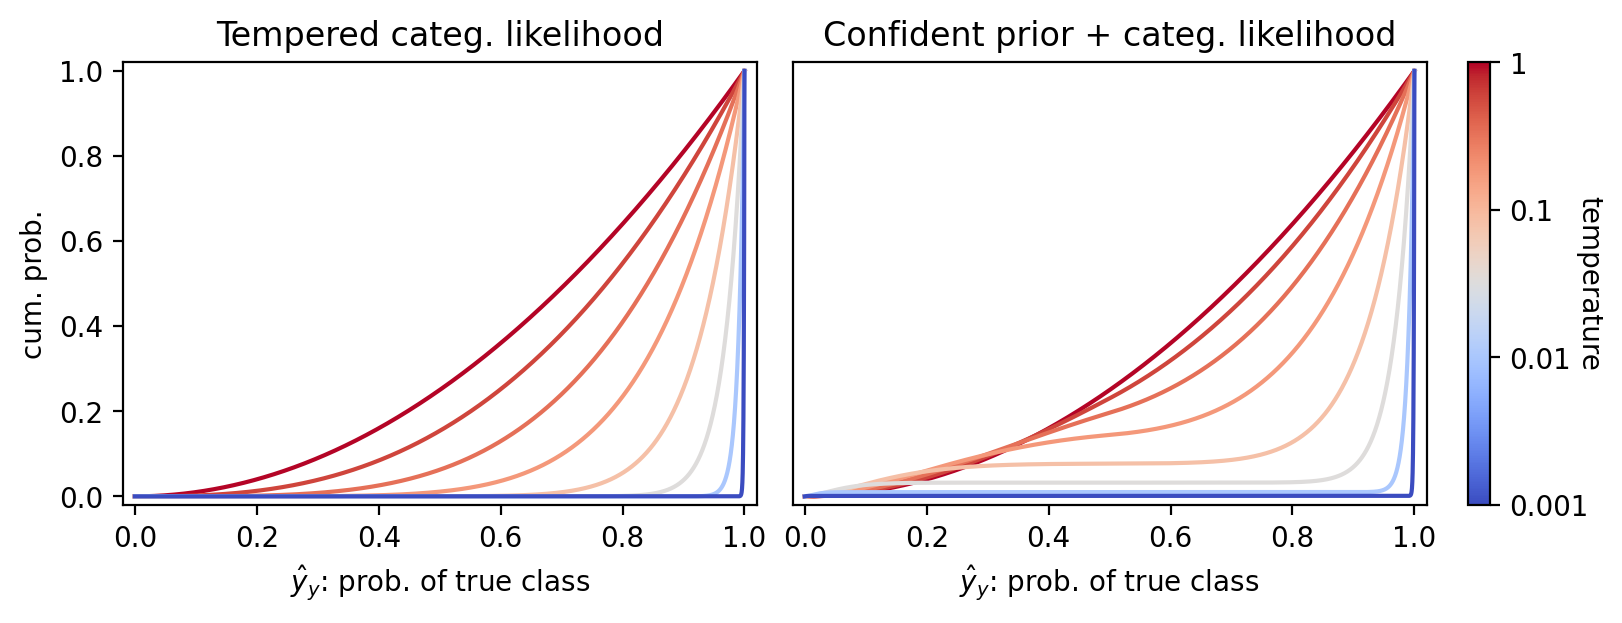

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), layout='constrained')
z = jnp.linspace(0, 1, 10_000)

# set temperatures to plot
temps = 1 / jnp.array([1, 1.7, 3, 5.5, 12, 30, 100, 1000])
color_mapper = mpl.cm.ScalarMappable(cmap='coolwarm')
colors = color_mapper.to_rgba(jnp.log(temps))

# plot density for each temperature
for ax, cdf_fn in zip(axs, (cdf_cold_fn, cdf_conf_fn)):
    for T, c in zip(temps, colors):
        ax.plot(z, cdf_fn(z, T), c=c)

# colorbar
cbar = fig.colorbar(color_mapper, ax=axs[1], location='right', format=lambda x, _: f'{np.round(np.exp(x), decimals=5):g}')
cbar.set_ticks(jnp.log(jnp.array([1, 0.1, 0.01, 0.001])))
cbar.ax.set_ylabel('temperature', rotation=-90, labelpad=5)
    
# extras
axs[0].set_ylabel('cum. prob.')
axs[0].set_title('Tempered categ. likelihood')
axs[1].set_title('Confident prior + categ. likelihood')
axs[1].tick_params(left=False)
axs[1].set(yticklabels=[])
for ax in axs:
    ax.set_ylim((-0.02, 1.02))
    ax.set_xlim((-0.02, 1.02))
    ax.set_xticks(jnp.linspace(0, 1, 6))
    ax.set_xlabel('$\\hat{y}_y$: prob. of true class')

# plt.savefig('../plots/cold_vs_conf_cdf.pdf')
plt.show()

# compute Wasserstein distance

In [9]:
%%time
dist = []
z = jnp.linspace(0, 1, 10_000)
# temps = jnp.linspace(0, 1, 1_000)
temps = jnp.geomspace(1e-5, 1, 1_000)
for T in temps:
    y_cold = cdf_cold_fn(z, T)
    y_conf = cdf_conf_fn(z, T)
    cdf_diff = jnp.abs(y_cold - y_conf)
    was_dist = jax.scipy.integrate.trapezoid(cdf_diff, z)
    dist += [was_dist]
dist = jnp.array(dist)

CPU times: user 1.22 s, sys: 28.6 ms, total: 1.25 s
Wall time: 1.01 s


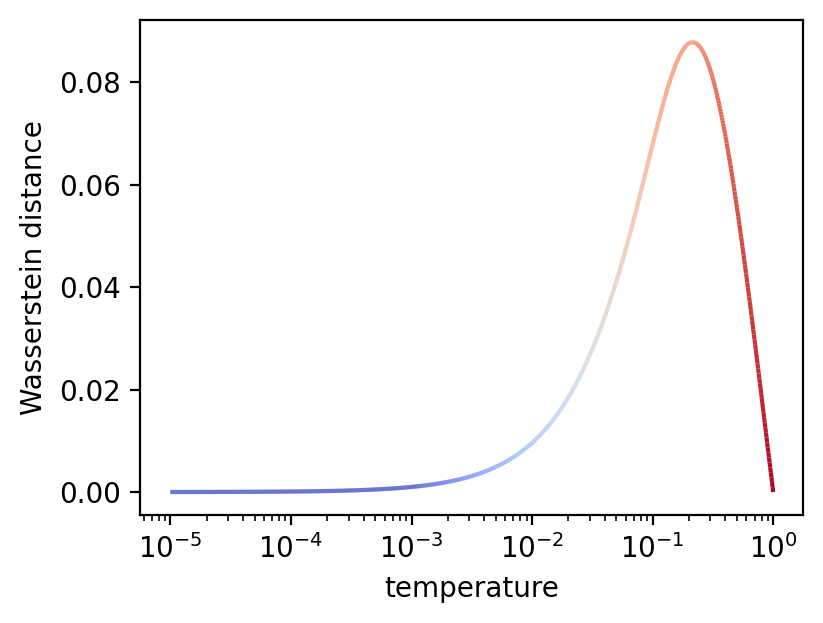

In [10]:
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')

# fancy way to plot x=temps, y=dist with a colored line
points = jnp.stack([temps, dist], 1)
segments = jnp.stack([points[:-1], points[1:]], axis=1)
color_mapper = mpl.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=jnp.log(1e-3), vmax=jnp.log(1)))
colors = color_mapper.to_rgba(jnp.log(temps))
lc = mpl.collections.LineCollection(segments, colors=colors)
ax.add_collection(lc)
ax.autoscale_view(True, True, True)

ax.set_xscale('log')
ax.set_xlabel('temperature')
ax.set_ylabel('Wasserstein distance')
# plt.savefig('../plots/conf_prior_wasserstein.pdf')
plt.show()

# validation: do analytical CDFs match simulation?

- sample probabilities for two classes uniformly
- weigh each drawn sample using unnormalized likelihood function
- compare emprirical CDF with analytical solutions

In [11]:
%%time
# sample probs uniformly
key = jax.random.PRNGKey(0)
n_class = 2
n_samples = 10_000_000
p0 = jax.random.uniform(key, [n_samples])
probs = jnp.stack([p0, 1-p0], -1)
logprobs = jnp.log(probs)

CPU times: user 628 ms, sys: 99.1 ms, total: 727 ms
Wall time: 231 ms


In [12]:
def categ_logpdf(logp, T=1):
    return logp[0] / T

def confidence_logpdf(logp, T):
    return logp[0] + (1/T-1) * logp.max()

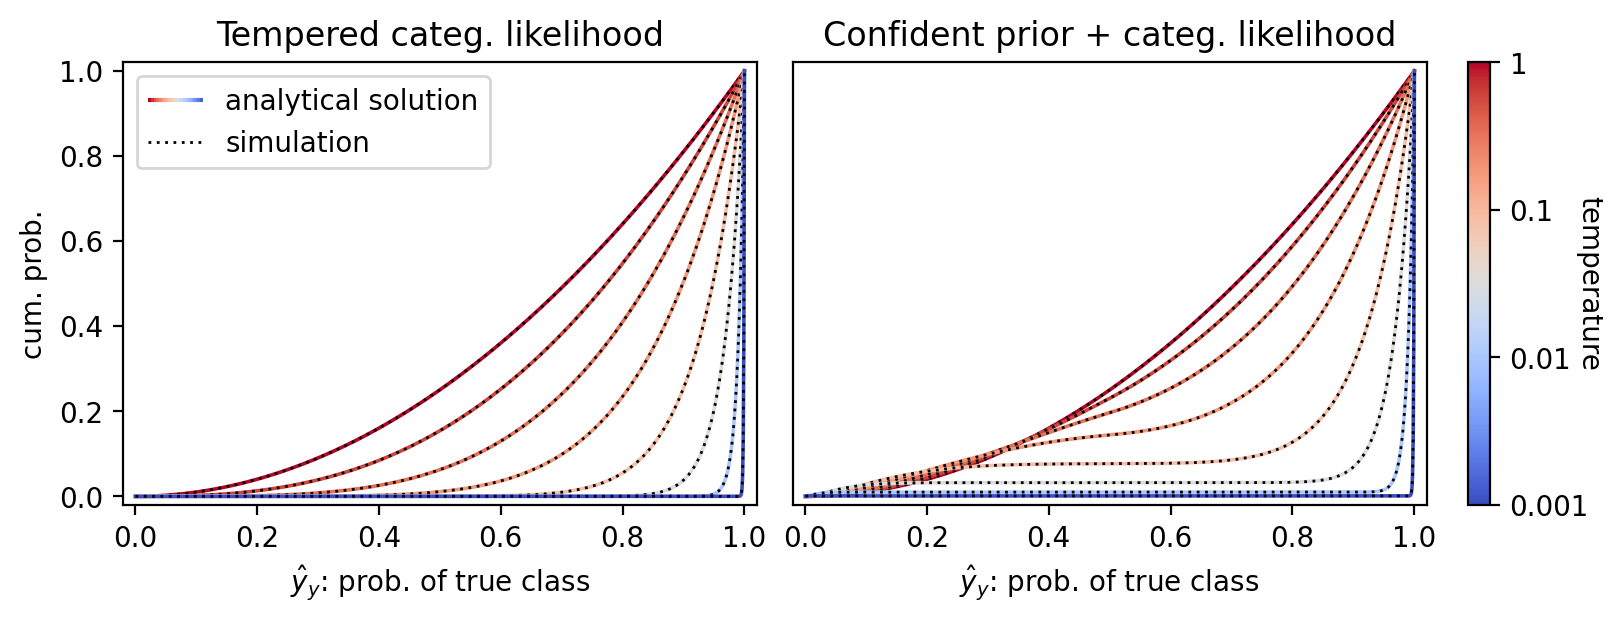

CPU times: user 8 s, sys: 2.69 s, total: 10.7 s
Wall time: 4.18 s


In [13]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(8, 3), layout='constrained')
bins = jnp.linspace(0, 1, 1_000)
x = bins[1:]

# set temperatures to plot
temps = 1 / jnp.array([1, 1.7, 3, 5.5, 12, 30, 100, 1000])
color_mapper = mpl.cm.ScalarMappable(cmap='coolwarm')
colors = color_mapper.to_rgba(jnp.log(temps))

# CDF of probability of true class
for ax, pdf_fn, cdf_fn in zip(axs, (categ_logpdf, confidence_logpdf), (cdf_cold_fn, cdf_conf_fn)):
    for T, c in zip(temps, colors):

        # analytical CDF
        y = cdf_fn(x, T)
        ax.plot(x, y, c=c, lw=1.3)

        # empirical  CDF
        label = 'simulation' if T==1 else None
        dens = jnp.exp(vmap(partial(pdf_fn, T=T))(logprobs))
        freq, bins = jnp.histogram(probs[:, 0], bins=bins, weights=dens)
        ax.plot(x, jnp.cumsum(freq) / dens.sum(), lw=1, c='black', ls=(0, (1, 2)), label=label)
    
# colorbar
cbar = fig.colorbar(color_mapper, ax=axs[1], location='right', format=lambda x, _: f'{np.round(np.exp(x), decimals=5):g}')
cbar.set_ticks(jnp.log(jnp.array([1, 0.1, 0.01, 0.001])))
cbar.ax.set_ylabel('temperature', rotation=-90, labelpad=5)

# legend
def make_gradient_line(x0, y0, w, h, n_rectangles=50):
    colors = mpl.cm.coolwarm(np.linspace(1, 0, n_rectangles))
    x = np.linspace(x0, x0+w, n_rectangles)
    y = np.repeat((y0 + h/2), n_rectangles)
    points = jnp.stack([x, y], 1)
    segments = jnp.stack([points[:-1], points[1:]], axis=1)
    line_collection = mpl.collections.LineCollection(segments, edgecolors=colors)
    return line_collection
class GradientLegendHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        w, h = handlebox.width, handlebox.height
        line_collection = make_gradient_line(x0, y0, w, h, 20)
        handlebox.add_artist(line_collection)
        return line_collection
handles, labels = ax.get_legend_handles_labels()
handles = (mpl.lines.Line2D([0], [0], label='analytical solution'), *handles)
axs[0].legend(loc='upper left', handles=handles, handler_map={handles[0]: GradientLegendHandler()})
    
# extras
axs[0].set_ylabel('cum. prob.')
axs[0].set_title('Tempered categ. likelihood')
axs[1].set_title('Confident prior + categ. likelihood')
axs[1].tick_params(left=False)
axs[1].set(yticklabels=[])
for ax in axs:
    ax.set_ylim((-0.02, 1.02))
    ax.set_xlim((-0.02, 1.02))
    ax.set_xticks(jnp.linspace(0, 1, 6))
    ax.set_xlabel('$\\hat{y}_y$: prob. of true class')

# plt.savefig('../plots/cold_vs_conf_cdf_validation.pdf')
plt.show()

# CDF(0.5)

In [14]:
T = 3e-7
z = 0.5
cdf_conf_fn(z, T)

Array(2.9999991e-07, dtype=float64, weak_type=True)

In [15]:
f'{1-3e-7:%}'

'99.999970%'